## Alternative assignment

Here you can find an alternative assignment notebook which does not require py2 or a physical screen.

For starters, please go to __qlearning.py__ file in the current folder and implement q-learning agent by following instructions in the file.

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

### Demo on taxi

Here we use the qlearning agent from before on taxi env from openai gym.
You will need to insert a few agent functions here.

In [2]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

[2017-09-16 10:24:06,773] Making new env: Taxi-v2


In [3]:
from qlearning import QLearningAgent

agent = QLearningAgent(alpha=0.5,epsilon=0.1,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

In [4]:
def play_and_train(env,agent,t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.getAction(s)
        #<get agent to pick action given state s>
        
        next_s,r,done,_ = env.step(a)
        
        #<train(update) agent for state s>
        agent.update(s, a, next_s, r)
        
        s = next_s
        total_reward +=r
        if done:
            break
        
    return total_reward
    
        
    

0.0405980235923


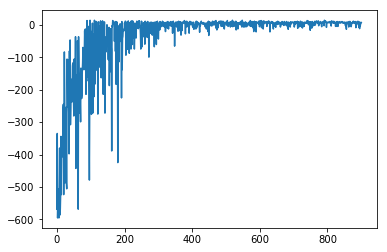

In [5]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))
    
    agent.epsilon *= 0.999
    
    if i %100 ==0:
        clear_output(True)
        print agent.epsilon
        plt.plot(rewards)
        plt.show()
        

# Main assignment

Use agent to train efficiently on CartPole-v0

This environment has a continuous number of states, so you will have to group them into bins somehow.

The simplest way is to use `round(x,n_digits)` (or numpy round) to round real number to a given amount of digits.

The tricky part is to get the n_digits right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

In [6]:
import math

In [267]:
#run xvfb and set %env DISPLAY=:1 if in binder or on a server
env = gym.make("CartPole-v0")
n_actions = env.action_space.n
state_bounds = zip(env.observation_space.low, env.observation_space.high)
state_bounds[1] = [-0.5, 0.5]
state_bounds[3] = [-math.radians(50), math.radians(50)]
state_bounds

[2017-09-16 18:39:28,062] Making new env: CartPole-v0


[(-4.7999999999999998, 4.7999999999999998),
 [-0.5, 0.5],
 (-0.41887902047863906, 0.41887902047863906),
 [-0.8726646259971648, 0.8726646259971648]]

In [295]:
def get_state(state):
    return (round(state[0], 1), round(state[1], 1), round(state[2], 2), round(state[3], 2))
    
def get_state2(state):
    pos_step = (state_bounds[0][1] - state_bounds[0][0])/1
    cart_pos_bins = np.arange(state_bounds[0][0], state_bounds[0][1], pos_step)
    pos_state = int(np.digitize(state[0], cart_pos_bins))
    
    vel_step = (state_bounds[1][1] - state_bounds[1][0])/1
    cart_vel_bins = np.arange(state_bounds[1][0], state_bounds[1][1], vel_step)
    vel_state = int(np.digitize(state[1], cart_vel_bins))
    
    an_step = (state_bounds[2][1] - state_bounds[2][0])/6
    an_pol_bins = np.arange(state_bounds[2][0], state_bounds[2][1], an_step)
    an_state = int(np.digitize(state[2], an_pol_bins))
    
    an_vel_step = (state_bounds[3][1] - state_bounds[3][0])/3
    an_vel_pol_bins = np.arange(state_bounds[3][0], state_bounds[3][1], an_vel_step)
    an_vel_state = int(np.digitize(state[3], an_vel_pol_bins))
    
    return (pos_state, vel_state, an_state, an_vel_state)

In [347]:
def get_explore_rate(t):
    return max(0.01, min(1, 1.0 - np.log10((t+1)/20)))

def get_learning_rate(t):
    return max(0.1, min(0.7, 1.0 - np.log10((t+1)/20)))

In [348]:
def change_exploration_lin(t, start=0.1, end=0.01, max_steps=1000):
    u, v = 1.0*(end - start)/max_steps, start
    return u*t + v

def change_learning_rate_lin(t, start=0.5, end=0.1, max_steps=1000):
    u, v = 1.0*(end - start)/max_steps, start
    return u*t + v                                              

('first state:', (0, 0, 2, 1))


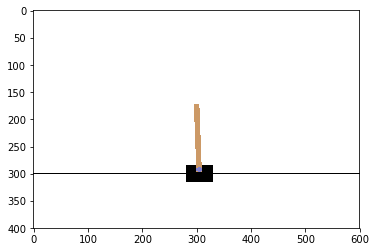

In [349]:
print("first state:", get_state3(env.reset()))
plt.imshow(env.render('rgb_array'))

In [353]:
def play_and_train(env, agent, t_max=10**4, render=False):
    total_reward = 0.0
    s = env.reset()
    
    for t in xrange(t_max):
        if render:
            env.render()
        a = agent.getAction(get_state2(s))
        next_s, r, done, _ = env.step(a)
        agent.update(get_state2(s), a, get_state2(next_s), r)
        s = next_s
        total_reward += r
        if done:
            break
        
    return total_reward

In [358]:
agent = QLearningAgent(alpha=0.7, epsilon=0.2, discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

0.01


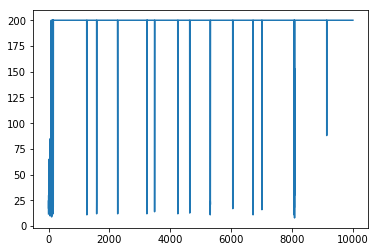

In [359]:
rewards = []
alphas = []
epsilons = []
num_epochs = 10000

for i in range(num_epochs):
    rewards.append(play_and_train(env, agent))
    agent.epsilon = get_explore_rate(i)
    agent.alpha = get_learning_rate(i)
    
    alphas.append(agent.alpha)
    epsilons.append(agent.epsilon)
    
    if i %100 == 0:
        clear_output(True)
        print agent.epsilon
        plt.figure(figsize=(15,6))
        plt.subplot(131)
        plt.plot(rewards)
        plt.subplot(132)
        plt.plot(alphas)
        plt.subplot(133)
        plt.plot(epsilons)
        plt.show()
clear_output(True)
print agent.epsilon
plt.plot(rewards)
plt.show()

In [355]:
# Test for solved
for i in range(100):
    rewards.append(play_and_train(env, agent, render=True))
print "Mean rewards after {} games is {}".format(100, np.array(rewards).mean())

Mean rewards after 100 games is 196.330588235
